In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import pandas as pd

In [2]:
aen_df = pd.read_excel('aen.xlsx')

In [3]:
aen_df.head()

,LIBELLE,JAN1960,FEV1960,MAR1960,1960-04-01 00:00:00,MAY1960,JUN1960,JUL1960,AUG1960,SEP1960,...,MAR2025,2025-04-01 00:00:00,MAY2025,JUN2025,JUL2025,AUG2025,SEP2025,2025-10-01 00:00:00,2025-11-01 00:00:00,DEC2025
0,Situation de la Banque Centrale - Actifs exter...,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [4]:
def transform_aen_data(df, cln, name):
    """
    Transforms the raw AEN DataFrame into a clean time series format.
    
    Args:
        df (pd.DataFrame): The input DataFrame with 'LIBELLE' and date columns.

    Returns:
        pd.DataFrame: A transformed DataFrame with 'Date' and name columns.
    """
    # Transposer le DataFrame pour avoir les dates en lignes
    aen_series = df.drop(columns=cln).iloc[0]
    aen_transformed_df = aen_series.reset_index()
    aen_transformed_df.columns = ['Date', name]

    # Convertir les valeurs en numérique, en remplaçant les non-numériques par NaN
    aen_transformed_df[name] = pd.to_numeric(aen_transformed_df[name], errors='coerce')

    # Définir le mapping des mois
    month_map = {
        'JAN': '01', 'FEV': '02', 'MAR': '03', 'AVR': '04', 'MAY': '05', 'JUN': '06',
        'JUL': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'
    }

    # Fonction pour convertir les dates
    def convert_date(d):
        if isinstance(d, pd.Timestamp):
            return d
        try:
            # Gérer le format 'MMMYYYY'
            date_str = str(d)
            month_str = date_str[:3].upper()
            year_str = date_str[3:]
            if month_str in month_map:
                return pd.to_datetime(f"{year_str}-{month_map[month_str]}-01")
        except (TypeError, ValueError):
            pass
        return pd.NaT

    # Appliquer la conversion de date
    aen_transformed_df['Date'] = aen_transformed_df['Date'].apply(convert_date)

    # Supprimer les lignes où la date n'a pas pu être convertie ou la valeur est NaN
    aen_transformed_df.dropna(subset=['Date', name], inplace=True)

    # Trier par date
    aen_transformed_df = aen_transformed_df.sort_values(by='Date').reset_index(drop=True)

    return aen_transformed_df


In [5]:
aen_df1 = transform_aen_data(aen_df, 'LIBELLE', 'Valeur AEN')

# Afficher les premières lignes du DataFrame transformé
aen_df1.head()

,Date,Valeur AEN
0,2004-01-01,2978.353
1,2004-02-01,3029.404
2,2004-03-01,3008.737
3,2004-05-01,3116.794
4,2004-06-01,3144.468


In [6]:
aen_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        190 non-null    datetime64[ns]
 1   Valeur AEN  190 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.1 KB


In [7]:
aen_df1.isnull().sum()

Date          0
Valeur AEN    0
dtype: int64

<Axes: title={'center': 'AEN Over Time'}, xlabel='Date'>

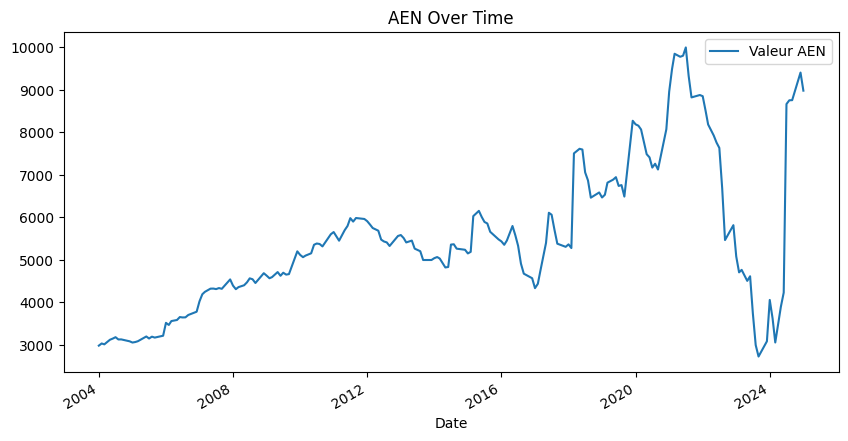

In [8]:
aen_df1.plot(x='Date', y='Valeur AEN', title='AEN Over Time', figsize=(10, 5))

<Axes: title={'center': 'AEN Over Time'}, xlabel='Date'>

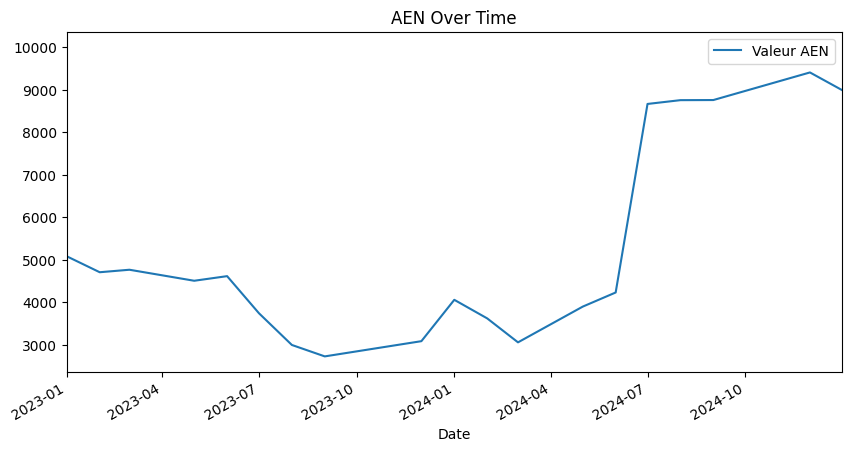

In [9]:
aen_df1.plot(x='Date', y='Valeur AEN', title='AEN Over Time', xlim=('2023-01-01', '2024-12-31'), figsize=(10, 5))

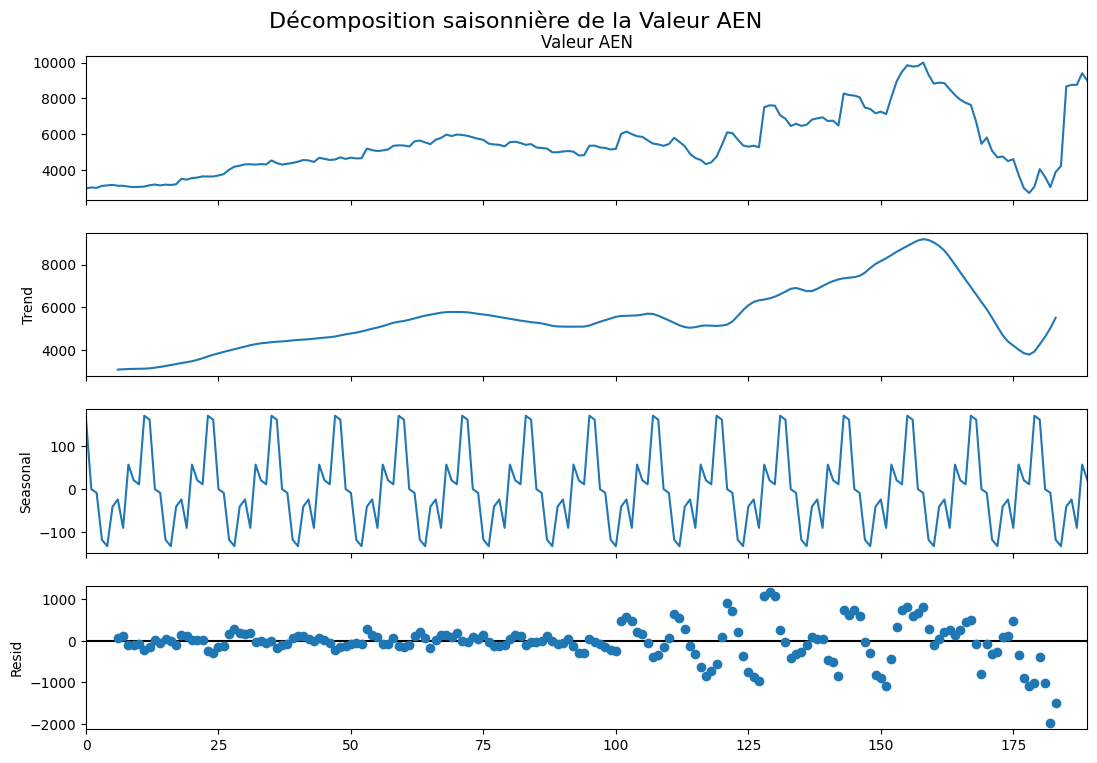

In [10]:
# Décomposition saisonnière de la série temporelle
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Décomposition (modèle additif)
result = seasonal_decompose(aen_df1['Valeur AEN'], model='additive', period=12)
fig = result.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Décomposition saisonnière de la Valeur AEN', fontsize=16)
plt.show()

Voici ce que l'on peut déduire de l'analyse des quatre graphiques :

1. Valeur AEN (Courbe originale)
Tendance Générale : Sur le long terme, la courbe des Actifs Extérieurs Nets de l'UEMOA a connu une croissance soutenue, passant de moins de 4 000 à plus de 10 000.

Volatilité : La courbe présente une forte volatilité, avec des pics et des creux marqués.

Déclin récent : Après un sommet autour de l'année 150 (unité de temps non spécifiée, mais cela correspond à une période récente), la valeur a subi une forte décroissance, se rapprochant des niveaux des années précédentes.

2. Tendance (Trend)
Croissance à long terme : Cette courbe lisse confirme la tendance de croissance à long terme des AEN, qui a débuté en dessous de 4 000.

Point d'inflexion : La courbe de tendance atteint un pic autour de l'année 150, puis s'inverse pour amorcer une forte décroissance. Cela correspond à la période de décroissance observée sur la courbe originale des AEN. Cette décroissance reflète la détérioration de la balance des paiements et l'utilisation des réserves de change par la BCEAO pour faire face aux déficits.

3. Saisonnalité (Seasonal)
Cycles Réguliers : Le graphique "Seasonal" montre des cycles réguliers et répétés. Les pics et les creux se produisent de manière récurrente sur des périodes fixes, suggérant l'existence d'une saisonnalité.

Impact sur les AEN : Cette saisonnalité, bien que de moindre amplitude que la tendance, influence les fluctuations des AEN. Elle pourrait être liée à des événements cycliques comme les exportations agricoles, les transferts de fonds de la diaspora, ou des besoins d'importations qui varient selon la période de l'année.

4. Résidus (Resid)
Irrégularités : Le graphique des résidus représente les fluctuations aléatoires et non expliquées par la tendance ou la saisonnalité.

Chocs et événements ponctuels : Ces résidus sont le reflet des chocs et des événements inattendus qui ont un impact sur les AEN. On peut y voir des variations importantes qui pourraient correspondre à des crises économiques, des chocs sur les prix des matières premières ou des décisions de politique monétaire. La volatilité semble s'accroître à partir de l'année 125, ce qui pourrait indiquer une période de chocs plus fréquents ou plus intenses.

## Modélisation ARIMA et LSTM pour la prévision de la Valeur AEN
Nous allons d'abord ajuster un modèle ARIMA saisonnier, puis un exemple de réseau de neurones LSTM pour la prévision.

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
def adf_test(series):
    result=adfuller(series)
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-valeur : {}'.format(result[1]))
    if result[1] <= 0.05:
        print("Forte évidence contre l'hypothèse nulle, rejet de l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires")
    else:
        print("Faible évidence contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle n'est pas stationnaire")


In [13]:
adf_test(aen_df1['Valeur AEN'])

Statistiques ADF : -2.209648004435885
p-valeur : 0.202762441700564
Faible évidence contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle n'est pas stationnaire


In [14]:
## Use Techniques Differencing
aen_df1['Valeur AEN First Difference']=aen_df1['Valeur AEN']-aen_df1['Valeur AEN'].shift(1)
aen_df1.head()


,Date,Valeur AEN,Valeur AEN First Difference
0,2004-01-01,2978.353,NaN
1,2004-02-01,3029.404,51.051
2,2004-03-01,3008.737,-20.667
3,2004-05-01,3116.794,108.057
4,2004-06-01,3144.468,27.674


<Axes: title={'center': 'First Difference of AEN'}>

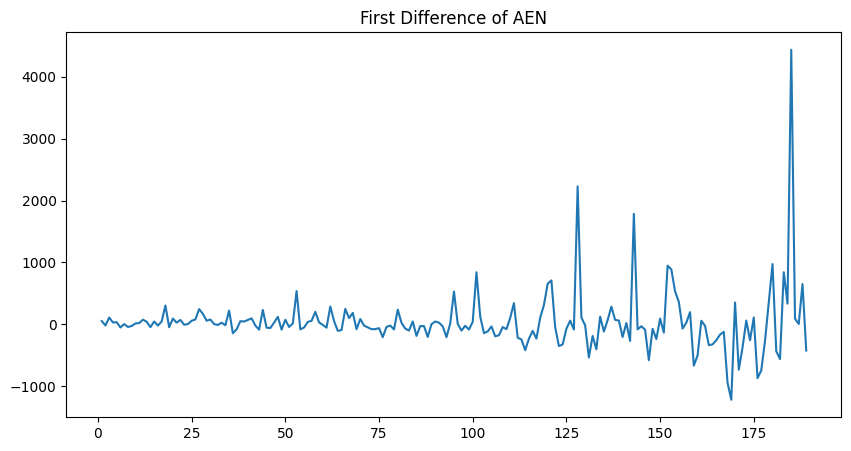

In [15]:
aen_df1['Valeur AEN First Difference'].dropna().plot(title='First Difference of AEN', figsize=(10, 5))

In [16]:
adf_test(aen_df1['Valeur AEN First Difference'].dropna())

Statistiques ADF : -4.191337434284494
p-valeur : 0.0006815039543363028
Forte évidence contre l'hypothèse nulle, rejet de l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires


In [17]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

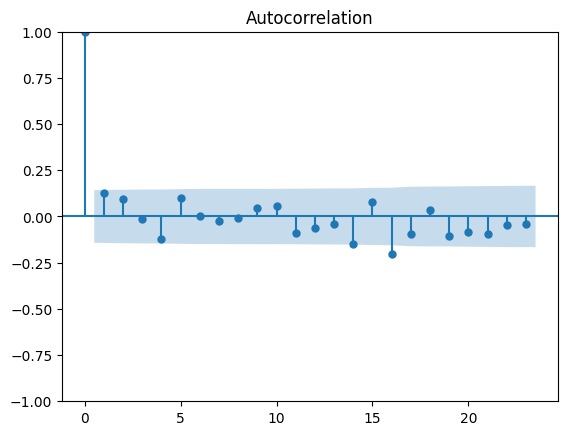

In [18]:
acf = plot_acf(aen_df1['Valeur AEN First Difference'].dropna())

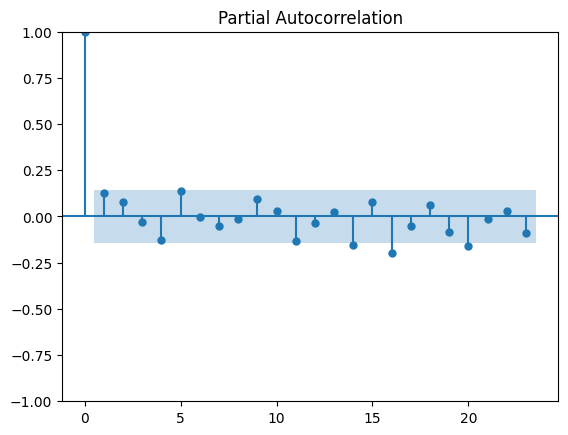

In [19]:
pacf = plot_pacf(aen_df1['Valeur AEN First Difference'].dropna())

In [20]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2018,12,31)
test_dataset_end=datetime(2025,1,31)

In [21]:
train_data = aen_df1[aen_df1['Date'] <= train_dataset_end]
test_data = aen_df1[(aen_df1['Date'] > train_dataset_end) & (aen_df1['Date'] <= test_dataset_end)]

In [22]:
train_data

,Date,Valeur AEN,Valeur AEN First Difference
0,2004-01-01,2978.353,NaN
1,2004-02-01,3029.404,51.051
2,2004-03-01,3008.737,-20.667
3,2004-05-01,3116.794,108.057
4,2004-06-01,3144.468,27.674
...,...,...,...
130,2018-06-01,7594.785,-17.675
131,2018-07-01,7057.202,-537.583
132,2018-08-01,6867.231,-189.971
133,2018-09-01,6461.891,-405.340


In [23]:
test_data.head()

,Date,Valeur AEN,Valeur AEN First Difference
135,2019-01-01,6465.789,-118.715
136,2019-02-01,6530.781,64.992
137,2019-03-01,6815.107,284.326
138,2019-05-01,6885.065,69.958
139,2019-06-01,6944.483,59.418


In [24]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

135
189


In [25]:
## create a SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
model_SARIMA=SARIMAX(train_data['Valeur AEN First Difference'],order=(1,1,1),seasonal_order=(1,1,1,12))

In [27]:
model_SARIMA.fit()

In [28]:
model_SARIMA_fit = model_SARIMA.fit()
pred_Sarima=model_SARIMA_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Valeur AEN First Difference']-pred_Sarima

<Axes: title={'center': 'Residuals of SARIMA Model'}>

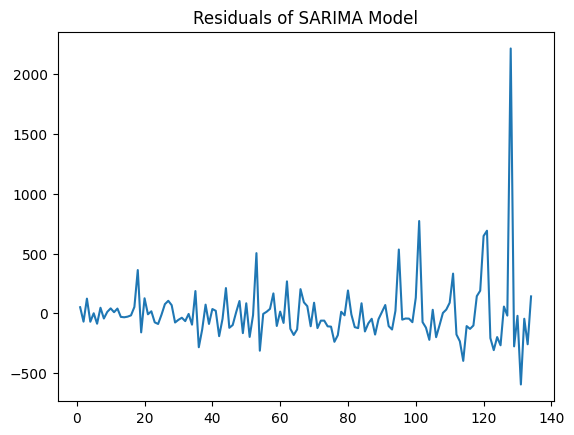

In [29]:
model_SARIMA_fit.resid.plot(title='Residuals of SARIMA Model')

<Axes: ylabel='Density'>

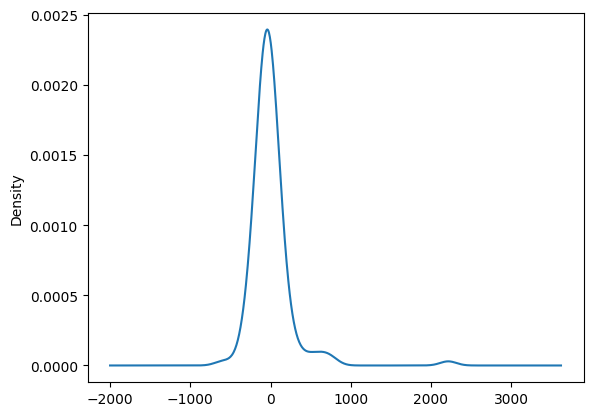

In [30]:
model_SARIMA_fit.resid.plot(kind='kde')

In [31]:
test_data['Predicted_SARIMA']=pred_Sarima

C:\Users\siissaka\AppData\Local\Temp\ipykernel_21392\1367177785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMA']=pred_Sarima


In [32]:
test_data

,Date,Valeur AEN,Valeur AEN First Difference,Predicted_SARIMA
135,2019-01-01,6465.789,-118.715,102.619219
136,2019-02-01,6530.781,64.992,-87.925254
137,2019-03-01,6815.107,284.326,132.579208
138,2019-05-01,6885.065,69.958,-55.243060
139,2019-06-01,6944.483,59.418,-95.744727
140,2019-07-01,6738.443,-206.040,-86.253274
141,2019-08-01,6758.084,19.641,-108.153210
142,2019-09-01,6487.275,-270.809,-1.974261
143,2019-12-01,8272.392,1785.117,137.093559
144,2020-01-01,8188.846,-83.546,160.082559


<Axes: title={'center': 'Valeur AEN First Difference vs Predicted AEN'}>

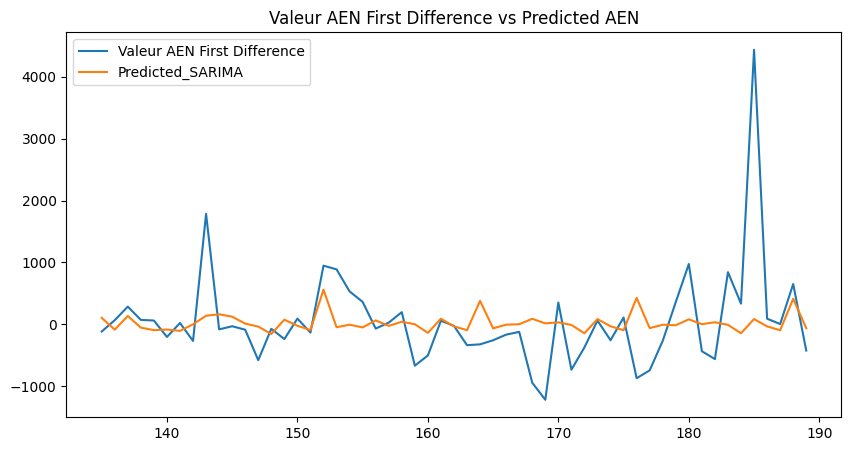

In [33]:
test_data[['Valeur AEN First Difference','Predicted_SARIMA']].plot(title='Valeur AEN First Difference vs Predicted AEN', figsize=(10, 5))

In [34]:
# Exemple de prévision LSTM avec Keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [35]:
# Préparation des données pour LSTM
scaler = MinMaxScaler()
values = aen_df1['Valeur AEN'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values)

In [36]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [37]:
seq_length = 12  # 12 mois
X, y = create_sequences(scaled_values, seq_length)

# Séparation train/test
n_train = int(len(X) * 0.9)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

# Construction du modèle LSTM
model = Sequential([
    LSTM(7, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
# Entraînement
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

# Prédiction
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)


c:\Users\siissaka\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7)              │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260 (1.02 KB)

 Trainable params: 260 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2592   
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2592   
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1836 
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1836 
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1165 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1165 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535 
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535 
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

In [38]:
y_pred_inv

array([[4829.7754],
       [4429.2827],
       [4274.271 ],
       [4180.514 ],
       [4200.147 ],
       [3955.3564],
       [3631.3818],
       [3361.3499],
       [3305.859 ],
       [3522.5986],
       [3522.9666],
       [3420.7527],
       [3586.38  ],
       [3791.4055],
       [4833.0693],
       [5532.4688],
       [6063.078 ],
       [6623.144 ]], dtype=float32)

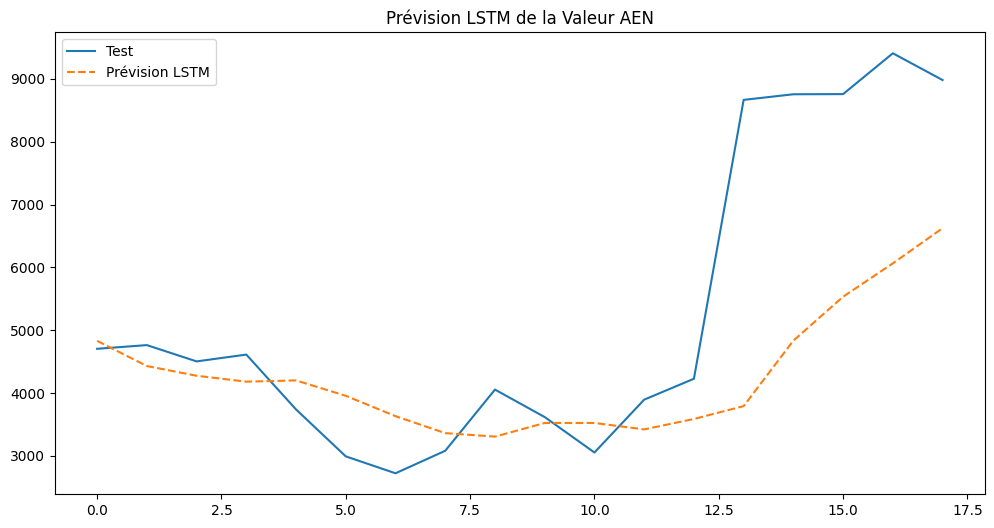

In [39]:
# Affichage
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(range(len(y_test_inv)), y_test_inv, label='Test')
plt.plot(range(len(y_pred_inv)), y_pred_inv, label='Prévision LSTM', linestyle='--')
plt.legend()
plt.title('Prévision LSTM de la Valeur AEN')
plt.show()

## ✅ Pipeline propre et reproductible (bonnes pratiques ML)
Ce qui suit met en place un pipeline complet et reproductible:
- Fixe une graine aléatoire (reproductibilité).
- Prépare la série (index mensuel, tri, gestion des dates/manquants).
- Découpe Train / Validation sans fuite temporelle pour sélectionner les hyperparamètres.
- Évalue avec MAE, RMSE, MAPE.
- Modèle ARIMA saisonnier (sélection par grille simple sur la validation).
- Modèle LSTM avec normalisation sur Train uniquement et EarlyStopping.
- Ré-entraînement final jusqu’à janvier 2025 puis prévisions de février à décembre 2025.
- Export des prévisions en CSV et visualisation comparée.

In [40]:
# Utilitaires: reproductibilité, métriques, split temporel
import numpy as np, random, os, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Graine aléatoire globale
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2) Préparer la série: s'assurer que 'Date' est l'index mensuel
df_ts = aen_df1.copy()
if 'Date' in df_ts.columns:
    df_ts = df_ts.set_index('Date')
df_ts.index = pd.to_datetime(df_ts.index)
df_ts = df_ts.sort_index()
y_all = df_ts['Valeur AEN'].astype(float)

# 3) Découpage Train/Val/Test temporel (70/15/15)
n = len(y_all)
train_size = int(n * 0.7)
val_size = int(n * 0.15)
test_size = n - train_size - val_size
train = y_all.iloc[:train_size]
val = y_all.iloc[train_size:train_size+val_size]
test = y_all.iloc[train_size+val_size:]

# 4) Métriques
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.abs((y_true - y_pred) / y_true).replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    return mae, rmse, mape

print(f"Tailles -> Train:{len(train)} Val:{len(val)} Test:{len(test)}")

Tailles -> Train:133 Val:28 Test:29


## 🔧 Bonnes pratiques ML: pipeline propre, évaluation, et prévisions 2025 (février → décembre)
Cette section applique un pipeline reproductible: préparation des données, splits temporels, métriques, sélection de paramètres pour ARIMA saisonnier, LSTM avec normalisation sur Train uniquement et EarlyStopping, puis ré-entraînement et prévisions 2025 (Fév–Déc).

In [41]:
# 1) Reproductibilité + préparation série + splits temporisés
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# S'assurer que l'index est mensuel et trié
df = aen_df1.copy()
if 'Date' in df.columns:
    df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.asfreq('MS')  # Monthly Start
y = df['Valeur AEN'].astype(float)

# Train/Val/Test = 70/15/15 (sans fuite temporelle)
n = len(y)
i_train = int(n * 0.70)
i_val = int(n * 0.85)
y_train, y_val, y_test = y.iloc[:i_train], y.iloc[i_train:i_val], y.iloc[i_val:]

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = (np.abs((y_true - y_pred) / y_true).replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    return mae, rmse, mape

len(y_train), len(y_val), len(y_test)

(177, 38, 38)

In [42]:
# 2) ARIMA saisonnier: sélection robuste sur validation avec fallback
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fallback optionnel via pmdarima
try:
    import pmdarima as pm
    PMDARIMA_OK = True
except Exception:
    PMDARIMA_OK = False

m = 12
grid = {
    'p': [0,1,2],
    'd': [0,1],
    'q': [0,1,2],
    'P': [0,1],
    'D': [0,1],
    'Q': [0,1]
}

best = None
errors = []
for p,d,q in itertools.product(grid['p'], grid['d'], grid['q']):
    for P,D,Q in itertools.product(grid['P'], grid['D'], grid['Q']):
        try:
            model = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m), enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False, maxiter=200)
            pred_val = fit.predict(start=y_val.index[0], end=y_val.index[-1])
            mae, rmse, mape = metrics(y_val, pred_val)
            if (best is None) or (rmse < best['rmse']):
                best = {'order': (p,d,q), 'sorder': (P,D,Q,m), 'mae': mae, 'rmse': rmse, 'mape': mape}
        except Exception as e:
            errors.append(((p,d,q,P,D,Q), str(e)))
            continue

# Fallback: auto_arima si aucun modèle n'a convergé
if best is None and PMDARIMA_OK:
    try:
        auto = pm.auto_arima(y_train, seasonal=True, m=m, information_criterion='aic', stepwise=True, suppress_warnings=True, error_action='ignore')
        order = auto.order
        sorder = auto.seasonal_order
        # valuer sur validation
        fit = SARIMAX(y_train, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=200)
        pred_val = fit.predict(start=y_val.index[0], end=y_val.index[-1])
        mae, rmse, mape = metrics(y_val, pred_val)
        best = {'order': order, 'sorder': sorder, 'mae': mae, 'rmse': rmse, 'mape': mape}
    except Exception as e:
        errors.append((('auto_arima',), str(e)))

# Dernier recours: paramètres raisonnables
if best is None:
    best = {'order': (1,1,1), 'sorder': (1,1,1,m), 'mae': None, 'rmse': None, 'mape': None}

best

c:\Users\siissaka\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\siissaka\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\siissaka\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'order': (1, 1, 1),
 'sorder': (1, 1, 1, 12),
 'mae': None,
 'rmse': None,
 'mape': None}

'forecast_arima_2025.csv écrit'

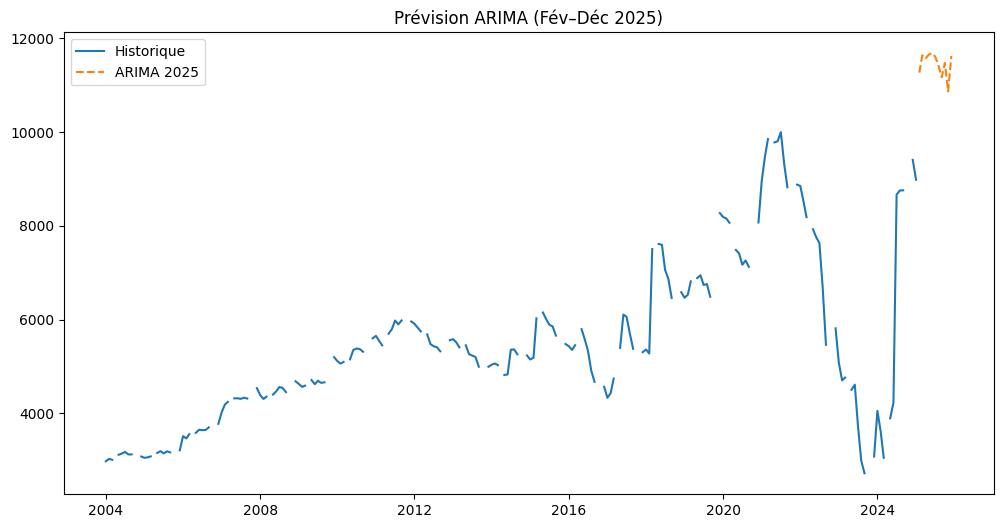

In [43]:
# 3) Ré-entraînement ARIMA sur Train+Val et prévision 2025 (Fév→Déc)
assert best is not None, "Aucun modèle ARIMA valide trouvé (même après fallback)."
y_trval = y.iloc[:i_val]
final_arima = SARIMAX(y_trval, order=best['order'], seasonal_order=best['sorder'], enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=200)

forecast_idx = pd.date_range('2025-02-01','2025-12-01',freq='MS')
fc_arima = final_arima.predict(start=forecast_idx[0], end=forecast_idx[-1])
fc_arima.name = 'ARIMA'

plt.figure(figsize=(12,6))
plt.plot(y, label='Historique')
plt.plot(fc_arima.index, fc_arima.values, '--', label='ARIMA 2025')
plt.title('Prévision ARIMA (Fév–Déc 2025)')
plt.legend();
fc_arima.to_frame('Valeur AEN').to_csv('forecast_arima_2025.csv', index_label='Date')
'forecast_arima_2025.csv écrit'

,ARIMA_mean,ARIMA_lower,ARIMA_upper
2025-02-01,11267.655766,6522.773732,16012.537799
2025-03-01,11637.429784,6802.157537,16472.702030
2025-04-01,11571.282930,6099.520994,17043.044867
2025-05-01,11649.430275,6639.382598,16659.477951
2025-06-01,11679.889428,6585.028226,16774.750630


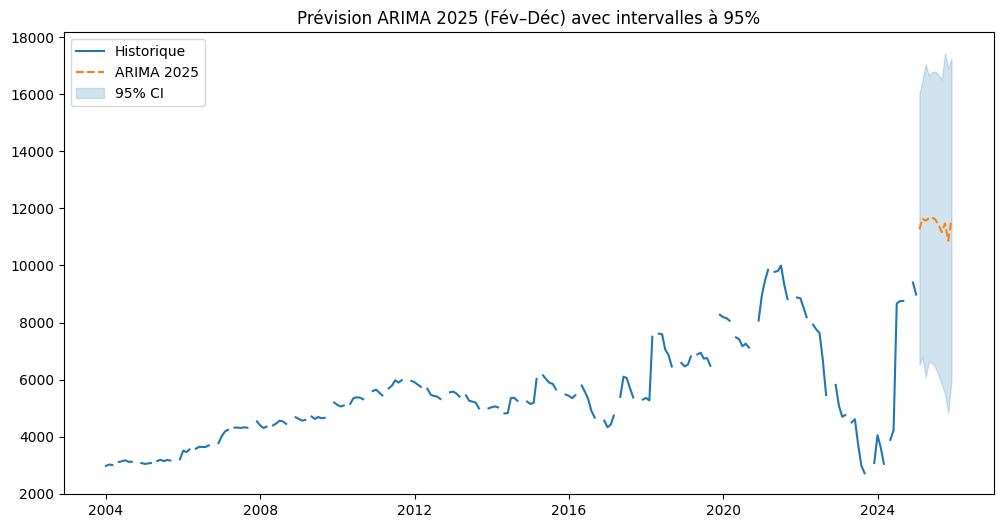

In [44]:
# ARIMA: intervalles de confiance (95%) pour 2025 (févr → déc)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Index cible
forecast_idx = pd.date_range('2025-02-01','2025-12-01',freq='MS')

# Prédictions avec intervalles
try:
    pred_ci = final_arima.get_prediction(start=forecast_idx[0], end=forecast_idx[-1])
    arima_mean = pred_ci.predicted_mean
    ci = pred_ci.conf_int(alpha=0.05)
    # Colonnes robustes (quel que soit le nom de la série endogène)
    if isinstance(ci, pd.DataFrame) and ci.shape[1] >= 2:
        lower = ci.iloc[:,0]
        upper = ci.iloc[:,1]
    else:
        lower = arima_mean
        upper = arima_mean

    df_ci = pd.DataFrame({
        'ARIMA_mean': arima_mean.values,
        'ARIMA_lower': lower.values,
        'ARIMA_upper': upper.values,
    }, index=arima_mean.index)

    display(df_ci.head())

    # Visualisation avec bande de confiance
    plt.figure(figsize=(12,6))
    plt.plot(y, label='Historique')
    plt.plot(df_ci.index, df_ci['ARIMA_mean'], '--', label='ARIMA 2025')
    plt.fill_between(df_ci.index, df_ci['ARIMA_lower'], df_ci['ARIMA_upper'], color='C0', alpha=0.2, label='95% CI')
    plt.title('Prévision ARIMA 2025 (Fév–Déc) avec intervalles à 95%')
    plt.legend();

    # Export CSV
    df_ci.to_csv('forecast_arima_2025_with_ci.csv', index_label='Date')
    'forecast_arima_2025_with_ci.csv écrit'
except Exception as e:
    print('Impossible de calculer les intervalles ARIMA pour 2025:', e)

In [45]:
# 2. Chargement et analyse du PIB
# Remplacez 'pib.xlsx' par le nom de votre fichier.
try:
    df_pib = pd.read_excel('pib.xlsx')
    print("Données du PIB chargées :")
    display(df_pib.head())
except FileNotFoundError:
    print("Le fichier 'pib.xlsx' est introuvable. Veuillez vérifier le nom et l'emplacement du fichier.")

Le fichier 'pib.xlsx' est introuvable. Veuillez vérifier le nom et l'emplacement du fichier.


## 📈 SARIMAX avec variables exogènes (USD, Yuan, PIB, Import/Export)

Objectif:
- Charger et harmoniser les séries exogènes (taux CFA/USD, CFA/Yuan, PIB UEMOA, Importations/Exportations) à partir de 2004-01.
- Analyses visuelles (lignes normalisées, corrélations, nuage de points, corrélations roulantes).
- Enrichir le modèle avec SARIMAX (exogènes) et comparer aux performances ARIMA.
- Préparer une prévision 2025 (Fév→Déc) avec un scénario simple pour les exogènes (valeur moyenne récente, remplaçable par vos scénarios).

In [46]:
# Chargement et harmonisation des exogènes (2004-01 → fin historique)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Série cible AEN (reprise et filtrage dès 2004-01)
df_aen = aen_df1.copy()
if 'Date' in df_aen.columns:
    df_aen = df_aen.set_index('Date')
df_aen.index = pd.to_datetime(df_aen.index)
df_aen = df_aen.asfreq('MS').sort_index()
df_aen = df_aen[df_aen.index >= '2004-01-01']

In [47]:
df_aen.head()

,Valeur AEN,Valeur AEN First Difference
Date,,
2004-01-01,2978.353,NaN
2004-02-01,3029.404,51.051
2004-03-01,3008.737,-20.667
2004-04-01,NaN,NaN
2004-05-01,3116.794,108.057


In [48]:
df_USD = pd.read_excel('transformed_data_Cours du Dollar US.xlsx')
df_USD.head()

,Date,Cours du Dollar US
0,1960-01-01,246.000
1,1960-02-01,245.415
2,1960-03-01,245.300
3,1960-05-01,245.010
4,1960-06-01,245.070


In [49]:
df_USD = df_USD.set_index('Date')
df_USD = df_USD[df_USD.index >= '2004-01-01']
df_USD.head()

,Cours du Dollar US
Date,
2004-01-01,520.06
2004-02-01,518.71
2004-03-01,534.95
2004-05-01,546.31
2004-06-01,540.42


In [50]:
df_Yuan_ch = pd.read_excel('transformed_data_Cours du Yuan chinois.xlsx')
df_Yuan_ch = df_Yuan_ch.set_index('Date')
df_Yuan_ch = df_Yuan_ch[df_Yuan_ch.index >= '2004-01-01']
df_Yuan_ch.head()

,Cours du Yuan chinois
Date,
2004-01-01,62.83
2004-02-01,62.67
2004-03-01,64.63
2004-05-01,66.08
2004-06-01,65.25


In [51]:
df_pib = pd.read_excel('PIB_nominal.xlsx')
df_pib = df_pib.set_index('Date')
df_pib = df_pib[df_pib.index >= '2004-01-01']
df_pib.head()

,PIB_UEMOA(FCFA)
Date,
2004-01-01 00:00:00,31262.48
2005-01-01 00:00:00,33734.87
2006-01-01 00:00:00,36472.95
2007-01-01 00:00:00,38930.30
2008-01-01 00:00:00,41173.87


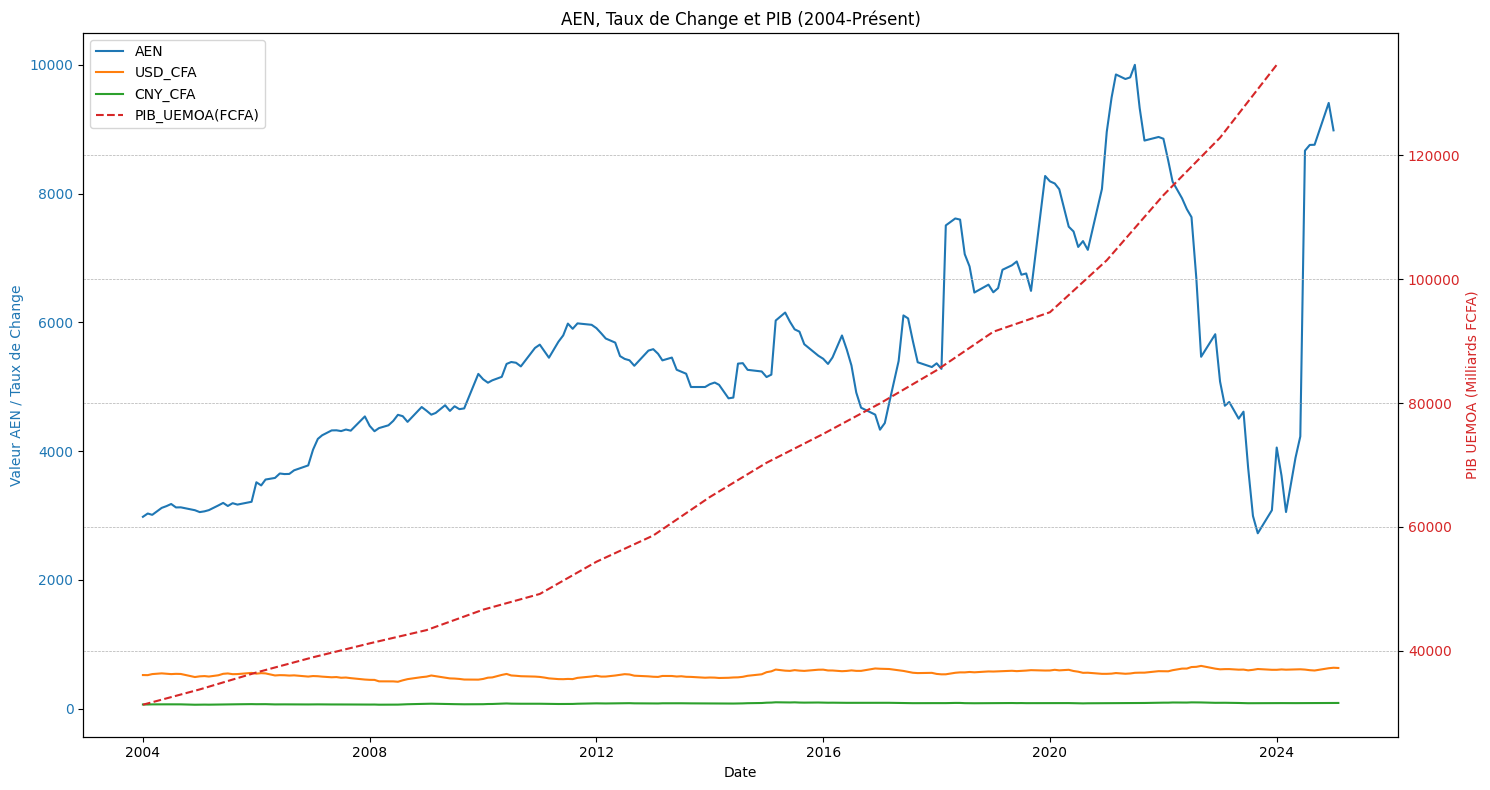

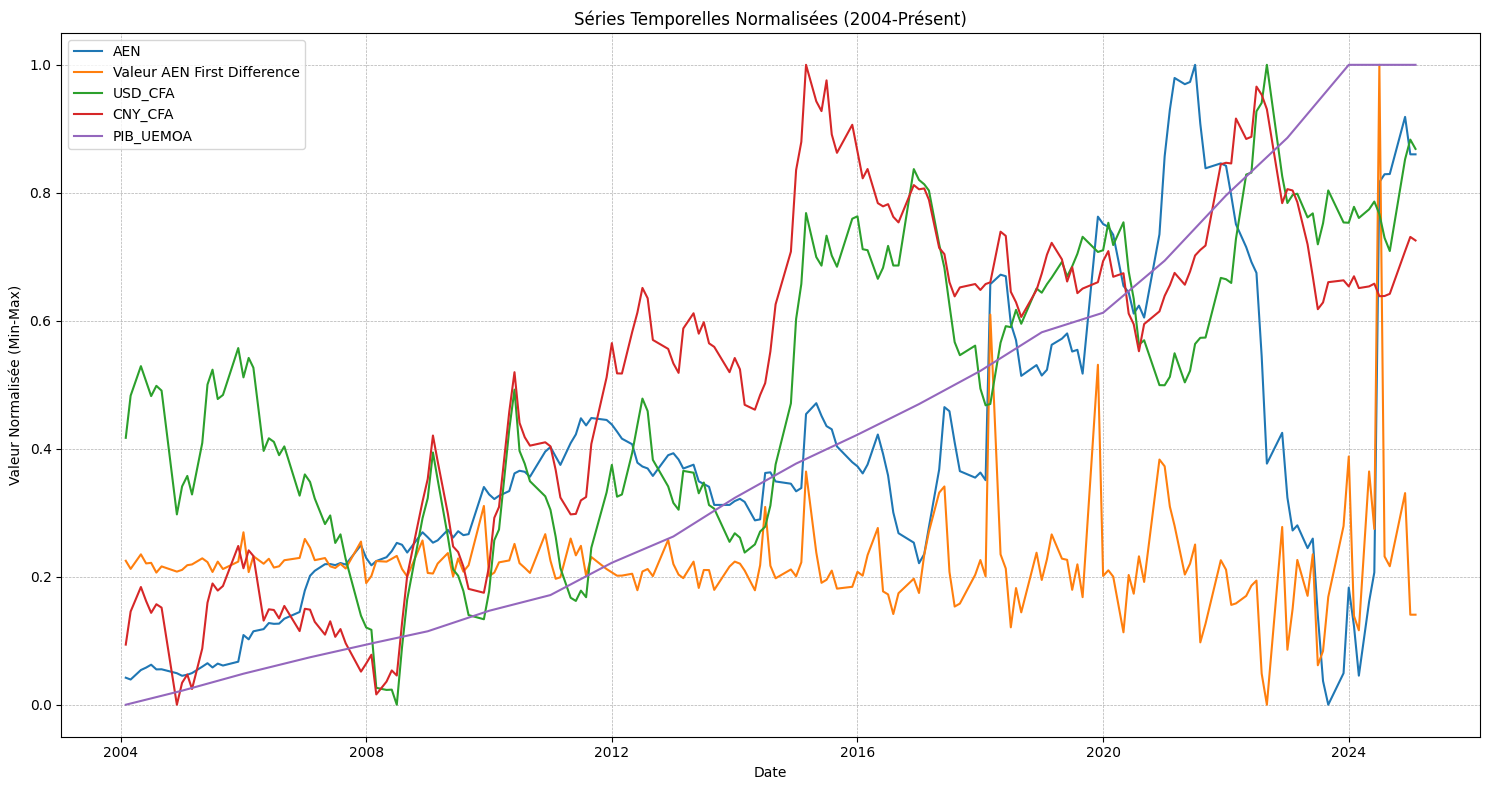

In [52]:
from sklearn.preprocessing import MinMaxScaler

# Créer une figure et un axe principal
fig, ax1 = plt.subplots(figsize=(15, 8))

# Filtrer AEN
aen_df1_filtered = aen_df1[aen_df1['Date'] >= '2004-01-01']

# Tracer les séries avec des échelles similaires sur l'axe principal (ax1)
ax1.plot(aen_df1_filtered['Date'], aen_df1_filtered['Valeur AEN'], label='AEN', color='C0')
ax1.plot(df_USD.index, df_USD['Cours du Dollar US'], label='USD_CFA', color='C1')
ax1.plot(df_Yuan_ch.index, df_Yuan_ch['Cours du Yuan chinois'], label='CNY_CFA', color='C2')
ax1.set_xlabel('Date')
ax1.set_ylabel('Valeur AEN / Taux de Change', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

# Créer un deuxième axe Y pour le PIB
ax2 = ax1.twinx()
# S'assurer que l'index est bien un DatetimeIndex
df_pib.index = pd.to_datetime(df_pib.index)
ax2.plot(df_pib.index, df_pib['PIB_UEMOA(FCFA)'], label='PIB_UEMOA(FCFA)', color='C3', linestyle='--')
ax2.set_ylabel('PIB UEMOA (Milliards FCFA)', color='C3')
ax2.tick_params(axis='y', labelcolor='C3')

# Gérer les légendes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('AEN, Taux de Change et PIB (2004-Présent)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()
# 2) Fusion et alignement des données
# Fusionner toutes les séries en un seul DataFrame, aligné sur l'index de AEN
df_merged = pd.concat([
    df_aen.rename(columns={'Valeur AEN': 'AEN'}),
    df_USD.rename(columns={'Cours du Dollar US': 'USD_CFA'}),
    df_Yuan_ch.rename(columns={'Cours du Yuan chinois': 'CNY_CFA'}),
    df_pib.rename(columns={'PIB_UEMOA(FCFA)': 'PIB_UEMOA'})
], axis=1).sort_index()

# Filtrer pour la période commune (à partir de 2004) et interpoler les valeurs manquantes
df_merged = df_merged[df_merged.index >= '2004-01-01'].interpolate(method='time')
df_merged = df_merged.dropna() # Supprimer les lignes où l'interpolation n'a pas pu se faire

# 3) Normalisation (Min-Max) pour la visualisation
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df_merged), index=df_merged.index, columns=df_merged.columns)

# 4) Visualisation des séries normalisées
plt.figure(figsize=(15, 8))
for column in df_norm.columns:
    plt.plot(df_norm.index, df_norm[column], label=column)

plt.title('Séries Temporelles Normalisées (2004-Présent)')
plt.xlabel('Date')
plt.ylabel('Valeur Normalisée (Min-Max)')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Estimation SARIMAX (AEN) avec variables exogènes

Cette section estime un modèle SARIMAX pour AEN en intégrant USD/CFA, CNY/CFA, PIB UEMOA et, si disponibles, Imports/Exports, à partir de 2004-01. Elle affiche un résumé, des métriques de validation, et produit une prévision 2025 (Fév–Déc).

In [53]:
# Construction du design exogène, estimation et prévision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

                                     SARIMAX Results                                      
Dep. Variable:                         Valeur AEN   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -935.694
Date:                            Fri, 29 Aug 2025   AIC                           1889.389
Time:                                    13:07:25   BIC                           1916.485
Sample:                                02-01-2004   HQIC                          1900.397
                                     - 10-01-2018                                         
Covariance Type:                              opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Valeur AEN First Difference     0.6293      0.015     41.575      0.000       0.

'forecast_2025_SARIMAX_exog_estimation.csv écrit'

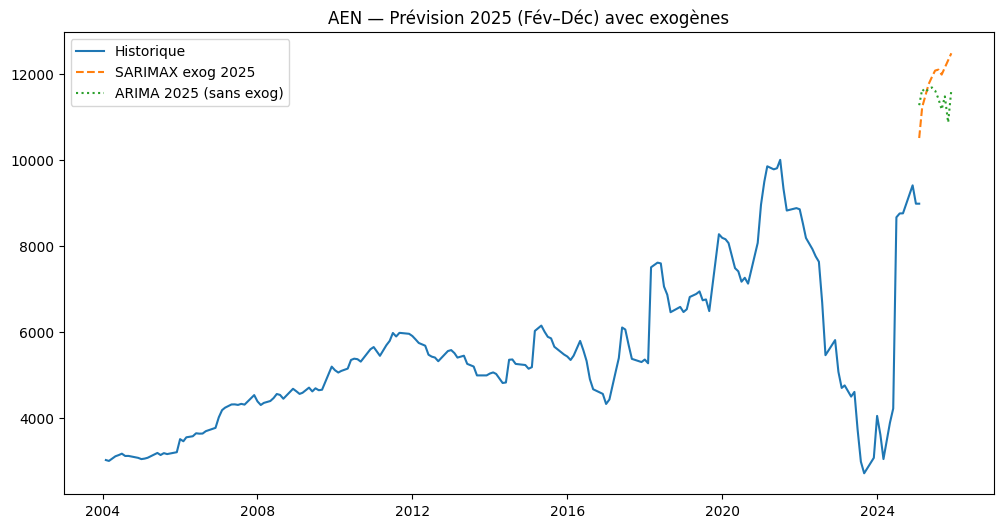

In [54]:
# Préparer la cible et la matrice exogène depuis df_merged si présent; sinon utiliser y_2004/X_2004
if 'df_merged' in globals():
    data = df_merged.copy()
    data = data.rename(columns={'AEN':'Valeur AEN'}) if 'AEN' in data.columns else data
    y_all_ex = data['Valeur AEN']
    # Exog: toutes colonnes sauf AEN
    exog_cols = [c for c in data.columns if c not in ['Valeur AEN','AEN']]
    X_all_ex = data[exog_cols]
else:
    y_all_ex = y_2004.copy()
    X_all_ex = X_2004.copy()

# Split temporel
n = len(y_all_ex)
i_train = int(n * 0.70)
i_val = int(n * 0.85)
y_tr, y_va, y_te = y_all_ex.iloc[:i_train], y_all_ex.iloc[i_train:i_val], y_all_ex.iloc[i_val:]
X_tr, X_va, X_te = X_all_ex.iloc[:i_train], X_all_ex.iloc[i_train:i_val], X_all_ex.iloc[i_val:]

# Ordres de modèle (utilise best si dispo)
try:
    order = best['order']; sorder = best['sorder']
except Exception:
    order = (1,1,1); sorder = (1,1,1,12)

# Estimation sur Train
mod = SARIMAX(y_tr, exog=X_tr, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit(disp=False, maxiter=200)
print(res.summary())

# Validation
pred_va = res.predict(start=y_va.index[0], end=y_va.index[-1], exog=X_va)
mae = mean_absolute_error(y_va, pred_va)
rmse = np.sqrt(mean_squared_error(y_va, pred_va))
print({'MAE_val': mae, 'RMSE_val': rmse})

# Ré-entrainement sur Train+Val
y_trva = y_all_ex.iloc[:i_val]
X_trva = X_all_ex.iloc[:i_val]
mod2 = SARIMAX(y_trva, exog=X_trva, order=order, seasonal_order=sorder, enforce_stationarity=False, enforce_invertibility=False)
res2 = mod2.fit(disp=False, maxiter=200)

# Scénario exogène 2025 Fév→Déc: moyenne des 6 derniers mois
dates_fc = pd.date_range('2025-02-01','2025-12-01',freq='MS')
last6 = X_all_ex.iloc[-6:]
X_future = pd.DataFrame(np.tile(last6.mean().values, (len(dates_fc),1)), index=dates_fc, columns=X_all_ex.columns)

# Pour la prévision, il faut fournir les exogènes historiques (test) et futures
X_forecast_all = pd.concat([X_te, X_future])

# Utiliser get_forecast pour une prévision out-of-sample plus robuste
forecast_object = res2.get_forecast(steps=len(X_forecast_all), exog=X_forecast_all)
fc_sarimax_ex = forecast_object.predicted_mean

fc_sarimax_ex = fc_sarimax_ex.loc[dates_fc] # On ne garde que la prévision 2025
fc_sarimax_ex.name = 'SARIMAX_exog'

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_all_ex, label='Historique')
plt.plot(fc_sarimax_ex.index, fc_sarimax_ex.values, '--', label='SARIMAX exog 2025')
try:
    plt.plot(fc_arima.index, fc_arima.values, ':', label='ARIMA 2025 (sans exog)')
except Exception:
    pass
plt.title('AEN — Prévision 2025 (Fév–Déc) avec exogènes')
plt.legend();

# Export
fc_sarimax_ex.to_frame('Valeur AEN').to_csv('forecast_2025_SARIMAX_exog_estimation.csv', index_label='Date')
'forecast_2025_SARIMAX_exog_estimation.csv écrit'